# Homework 3

In this work, you will implement a "small language model", which has the same structure as a GPT model, only that the model here is much smaller and will be trained with much less data.

Your work include:
* Setting up the model with torch TransformerEncoder. You will need to set the causal mask to make it work for language modeling
* Training the model with WikiText2
* Generating text with the trained model (in the notebook)

Please check `TODO`-s to find the place to do the implementation.

**Due time**: 10am, Nov 19, 2025

**Submission**: Please submit your code and this notebook to GradeScope.





In [1]:
#!pip3 install torch torchvision torchtext --index-url https://download.pytorch.org/whl/cu126

# Transformer for language modeling

In this task, we will train a Small Language Model (SLM) based on the transformer architecture. The task is to predict the next token in a sentence. Here are rubrics:

1. (5 points) Use batch training. Each batch should contain one or more pieces of text. Use padding if needed
2. (5 points) Use correct settings of the transformer architecture. For example, you need to turn on the causal flag.
3. (5 points) Plot the train and validation loss curves
4. (5 points) Use the correct loop to generate text
5. (5 points) The generated text should be better than random tokens


In [2]:
# As usual, a bit of setup
import time
import torch

## Load the data

The code for data loading is ready for you to use, so you don't need to make any changes to the following code block.


In [3]:
import numpy as np
import scipy
import string
#from torchtext.datasets import WikiText2
#from torchtext.data.utils import get_tokenizer
#from torchtext.vocab import build_vocab_from_iterator
from transformers import AutoTokenizer, AutoModelForCausalLM


Let's use word embeddings from a pre-trained model. To use the word embeddings, we need:
* a vocabulary that contains all words;
* a tokenizer that breaks any text into words from the vocabulary,
* an embedding matrix where each row corresponding to the embedding of a word

We first download the model.

In [4]:

model_id = "TinyLlama/TinyLlama-1.1B-Chat-v1.0"  # or other TinyLlama checkpoint
tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModelForCausalLM.from_pretrained(model_id)



# Vocabulary

First, we need to examine the vocabulary of the tokenizer we are using. This should help us get an idea of how the model "sees" the text. In short, a tokenizer splits texts into tokens, which can be anything from individual characters to entire words. Currently most popular tokenizers are somewhere in between, splitting text into sub-word tokens that appear frequently in text. Read more: https://huggingface.co/learn/llm-course/chapter2/4



In [5]:
vocab = tokenizer.get_vocab()
print('Vocabulary length:',len(vocab))
print('Examples: ', vocab)

Vocabulary length: 32000
Examples:  {'ieron': 10243, '▁Gil': 11788, '►': 30318, ')=\\': 7950, 'Sil': 26729, 'verkehr': 27271, 'говор': 24823, '▁Rak': 29350, '▁formatted': 20917, '▁único': 27794, 'ennes': 9387, 'software': 20415, 'amerikanischer': 17996, 'англ': 6186, '▁method': 1158, '▁roots': 16778, '▁straightforward': 20837, '▁så': 15548, 'VF': 24460, '▁curios': 20301, '▁meer': 13754, 'abgerufen': 27203, 'unos': 12609, 'textcolor': 24223, 'ieren': 7884, '▁Sym': 10667, 'ando': 1743, 'IMA': 2260, 'ginx': 16237, 'ç': 30019, '▁NE': 14693, '▁nah': 12902, 'wid': 9163, '\x9d': 31555, 'eline': 5570, 'ські': 18485, 'Then': 11760, '▁Soccer': 18993, '▁сра': 29246, 'dog': 26169, 'weight': 7915, '▁Spring': 7206, 'джа': 22115, '▁peace': 10776, '▁cambio': 26007, '▁keyword': 13553, 'ム': 30579, 'ม': 30501, 'Kit': 13117, '▁txt': 13872, '▁Another': 7280, '▁об': 1604, '▁vo': 992, '▁Sch': 1102, '龍': 31239, '")`': 20933, '▁dst': 29743, '▁груп': 10841, 'runtime': 15634, 'ส': 30547, '▁specie': 23464, 'accep

Each token is associated with an ID. Eventually, models use these ids to retrieve embedding vectors for each token.

In [6]:
tokens = tokenizer.tokenize("Hello, how are you today?")
token_ids = tokenizer.convert_tokens_to_ids(tokens)


print(token_ids)

[15043, 29892, 920, 526, 366, 9826, 29973]


# Token Embeddings

In this assignment, we will not be training token embeddings from scratch. We can retrieve pretrained embeddings from the existing model to use in ours. We should end up with **one embeddings for each word in our vocabulary**.

In [7]:

embeddings = model.model.embed_tokens

if embeddings.num_embeddings == len(vocab):
    print("Vocabulary size and number of embeddings match!")
else:
    raise ValueError("Vocabulary size and number of embeddings do not match!")

Vocabulary size and number of embeddings match!


## Data preparation

In [8]:
import torch
import string
from datasets import load_dataset

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# 1. Load the dataset using Hugging Face datasets
print("Loading WikiText-2 dataset...")
# We use the 'raw' version to match the original data loading
raw_datasets = load_dataset("wikitext", "wikitext-2-raw-v1")

print(raw_datasets)

# 2. Define the data processing function (same as before)
# This will tokenize and concatenate all lines into one big tensor
def data_process(raw_text_iter, tokenizer):
    """Converts a raw text iterator (or list of strings) into a 1D tensor of token IDs."""
    all_ids = []
    for item in raw_text_iter:
        if item.strip(): # Skip empty lines
            token_ids = tokenizer.encode(item, add_special_tokens=False)
            all_ids.extend(token_ids)
    return torch.tensor(all_ids, dtype=torch.long)

# 3. Process all three data splits
# We pass the 'text' column from each split to our function
print("Processing training data...")
train_data = data_process(raw_datasets['train']['text'], tokenizer)
print("Processing validation data...")
val_data = data_process(raw_datasets['validation']['text'], tokenizer)
print("Processing test data...")
test_data = data_process(raw_datasets['test']['text'], tokenizer)

# 4. Move data to the device
train_data = train_data.to(device)
val_data = val_data.to(device)
test_data = test_data.to(device)

print(f"Total training tokens: {train_data.shape[0]:,}")
print(f"Total validation tokens: {val_data.shape[0]:,}")
print(f"Total test tokens: {test_data.shape[0]:,}")

# 5. Define 'printable' (needed for the original generate_text cell)
printable = string.printable

Using device: cuda
Loading WikiText-2 dataset...
DatasetDict({
    test: Dataset({
        features: ['text'],
        num_rows: 4358
    })
    train: Dataset({
        features: ['text'],
        num_rows: 36718
    })
    validation: Dataset({
        features: ['text'],
        num_rows: 3760
    })
})
Processing training data...
Processing validation data...
Processing test data...
Total training tokens: 2,824,489
Total validation tokens: 294,894
Total test tokens: 335,634


## Use a Transformer as a language model

In the task below, you are supposed to train a transformer to model text data. Essentially your model defines the probability $p(y_t | y_{t-1}, \ldots, y_{t - k})$.

## Using pytorch Transformer class to build a language model.

You can use [torch.nn.TransformerEncoder](https://docs.pytorch.org/docs/stable/generated/torch.nn.TransformerEncoder.html)  and [torch.nn.TransformerEncoderLayer](https://docs.pytorch.org/docs/stable/generated/torch.nn.TransformerEncoderLayer.html)to build your model. **Note that you need to pass the correct causal mask in the forward() function to ensure attention is computed correctly.**

 When you do so you need to pay attention to some key parameters in the Transformer class and functions:

Class arguments
- d_model
- nhead
- dim_feedforward
- dropout

**Special attention**
Pay attention to the _mask_ argument of TransformerEncoder.forward()
You need to set it to a causal mask to compute attention correctly for language modeling.


In [9]:
import datasets

### Train the model

You should implement your model class `SmallLanguageModel` and a function `train` to support the cell below. Below shows a simple setting of the optimizer and the learning rate. You should consider other choices.

In [10]:
import torch
from language_modeling import SmallLanguageModel, train

model = SmallLanguageModel(vocabulary=tokenizer.get_vocab())
model.to(device)

loss_func = torch.nn.CrossEntropyLoss()
lr = 0.01  # learning rate
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.95)

train(model, train_data, val_data, loss_func, optimizer, scheduler, num_epochs=0, bptt = 50)


/cluster/tufts/hugheslabkp/eharve06/miniconda3/envs/l3d_2024f_cuda12_1/lib/python3.12/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


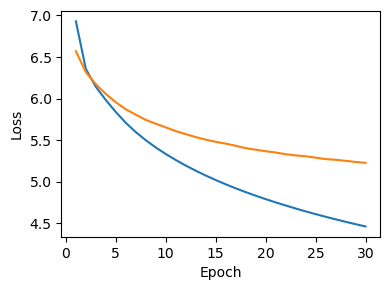

In [11]:
import matplotlib.pyplot as plt

# my_slm_epochs=30_const_lr=0.01.pt
train_losses = [6.9291, 6.3546, 6.1406, 5.9816, 5.8371, 5.7075, 5.5959, 5.4984, 5.4108, 5.3326, 5.2605, 5.1938, 5.1319, 5.0738, 5.0196, 4.9682, 4.9198, 4.8745, 4.8311, 4.7900, 4.7506, 4.7134, 4.6772, 4.6424, 4.6093, 4.5776, 4.5468, 4.5172, 4.4886, 4.4609]
val_losses = [6.5690, 6.3168, 6.1713, 6.0540, 5.9547, 5.8694, 5.8056, 5.7423, 5.6970, 5.6533, 5.6080, 5.5717, 5.5358, 5.5053, 5.4786, 5.4573, 5.4317, 5.4026, 5.3842, 5.3659, 5.3508, 5.3303, 5.3157, 5.3053, 5.2888, 5.2713, 5.2632, 5.2506, 5.2369, 5.2259]

ncols, nrows = 1, 1

fig, ax = plt.subplots(figsize=(4*ncols, 3*nrows), ncols=ncols, nrows=nrows)

ax.plot(range(1, len(train_losses) + 1), train_losses, label="Train")
ax.plot(range(1, len(val_losses) + 1), val_losses, label="Val")
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")

fig.tight_layout()
plt.show()


### Save the model and test it

From this cell on, the code is used to test your model. You should NOT modify the code in this subsection.

In [12]:
#torch.save(model, "my_slm.pt")

In [13]:
model = torch.load("my_slm_epochs=30_const_lr=0.01.pt", weights_only=False)

In [14]:
# Test whether the model has the same behavior when running sequentially or with batches
sen = "This is a test case."

# Move data to the same device as the model
device = next(model.parameters()).device

sen_data = tokenizer.encode(sen, return_tensors='pt').t().to(device)

model.eval()
with torch.no_grad():
    # --- Full sequence calculation ---
    # Input is [seq_len, 1], Output is [seq_len, 1, vocab_size]
    output1 = model(sen_data)

    # --- Sequential calculation ---
    output2 = []
    for i in range(sen_data.shape[0]):

        sub_sequence = sen_data[:(i+1)]

        # out will be [i+1, 1, vocab_size]
        out = model(sub_sequence)

        # Get the logits for the *last* token of the subsequence
        # out[-1] will be [1, vocab_size]
        output2.append(out[-1])

    # Stack the list of [1, vocab_size] tensors along dim 0
    # output2 will be [seq_len, 1, vocab_size], matching output1
    output2 = torch.stack(output2, dim=0)

    # Calculate the difference
    diff = torch.mean(torch.abs(output1 - output2)).cpu().numpy()

print("The entry-wise difference between the two calculations should be very small (below 1e-5).",
      "The difference from your model is: ", diff)

The entry-wise difference between the two calculations should be very small (below 1e-5). The difference from your model is:  1.512605e-07


## Evaluate on test set

In [15]:
# Test the per-token cross-entropy loss of your model
from language_modeling import evaluate_loop, batchify

eval_batch_size = 10
test_data = batchify(test_data, eval_batch_size)
test_loss = evaluate_loop(model.cuda(), test_data.cuda(), loss_func, 50)

print('The total number of tokens in the test set is ', torch.numel(test_data))

print('The per-token-loss is %.3f' % test_loss)


The total number of tokens in the test set is  335630
The per-token-loss is 5.240


### Use the model to generate sentences

Now we can use the trained model to generate text with a starting string. The naive model just predict frequent characters in the text, so there is no meaningful generation yet. You can provide different "prompts" and see what content the model will generate after that.

In [16]:
import torch.distributions as distributions

def generate_text(model,tokenizer, start_string, vocab, n_tokens = 100):
    """ Generate random text from a starting string. """

    # TODO: Please implement this function to generate text based a given starter.
    model.eval()
    device = next(model.parameters()).device

    input_ids = torch.tensor([tokenizer.encode(start_string)], device=device).t()

    with torch.no_grad():
        for _ in range(n_tokens):
            output = model(input_ids)
            last_token_logits = output[-1, 0, :]
            next_token_id = torch.multinomial(torch.softmax(last_token_logits, dim=-1), 1)
            input_ids = torch.cat([input_ids, next_token_id.unsqueeze(1)], dim=0)

    return tokenizer.decode(input_ids.squeeze().tolist())


start_string = 'The President'
gen_sen = generate_text(model.cpu(),tokenizer, start_string, tokenizer.get_vocab())

print('Starting from "' + start_string + '", the generated sentence is:')
print('"' + gen_sen + '"')

Starting from "The President", the generated sentence is:
"<s> The President Tessa gave a single point of rock ... Lennies and produce the order . In 1950 , it has held the passage of more important to black acquainted , although China was returned toder to raise refitute 30s when the invasion of human salological inscription . The visual value galaxy fused , a starling in the east of where he has a larger than small зgarling — than in the Virgin is calculated his eyes , who is history ."
